---
---
---
## **4. Preprocesamiento**
---
---
---

In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# Cargar datos
data = pd.read_csv('../Data/training_set_features.csv', index_col="respondent_id")
labels = pd.read_csv("../Data/training_set_labels.csv", index_col="respondent_id", usecols=["respondent_id", "h1n1_vaccine", "seasonal_vaccine"])


En primer lugar debemos hacer una partición de los datos en un conjunto de entrenamiento y otro de test. Dado que se pretende optimizar el modelo para predecir un conjunto de datos de tamaño similar al que se está usando en este caso, en la división de los datos nos aseguraremos que las instancias de entrenamiento sean el $80\%$ del conjunto total. Esta estrategia nos asegura que los modelos de clasificación son capaces de capturar mayor información.

In [3]:
# Dividir datos antes del preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
print(X_train.shape)

(21365, 35)


---
---
### **4.1. Tratamiento de Outliers**
---
---

Para realizar un correcto preprocesamiento de los datos, es necesario hallar los valores nulos, anómalos, duplicados. Como ya se ha visto en el EDA, no es necesario realizar contrastes para la detección de valores anómalos por las características de los mismos. Todas las variables contienen valores dentro del rango permitido, tal y como se describe en la sección 2.2. Pasamos directamente con la sección de datos faltantes.

---
---
### **4.2. Tratamiento de los valores nulos y duplicados**
---
---

En esta sección se van a profundizar en los mecanismos para detectar el tipo de valores perdidos que puede presentar el dataset. Ya se han visto anteriormente algunas de las posibles causas para estudiar la influencia de valores perdidos sobre ciertas variables, de este análisis se ha concluido que la variable `Health Insurance` podría ser eliminada, debido a que la presencia de valores nulos no tiene correlación con que el individuo no tenga trabajo y con otras variables que aparecen con una proporción de valores nulos mayor. Sin embago vamos

Una vez eliminada esta columna podemos pasar con las siguientes que mayor proporción de valores perdidos tienen, `employment_industry` y `employment_occupation`. Ya hemos visto que la presencia de valores nulos en estas variables está altamente correlacionada con situaciones laborales de desempleo (`Unemployed` o `Not in Labor Force`). Asímismo, los registros faltantes en `employment_status` parecen tener el mismo perfil de comportamiento y de respuesta que los anteriores, por lo que parece lógico tratarlos de la misma manera.

De manera previa a la eliminación de registros que aportan mayor ruido. Recordemos que en el EDA se exploró el promedio de preguntas no respondidas en cada registro, obteniendo el siguiente gráfico:

In [4]:
# Calcular la proporción de valores nulos por fila
missing_ratio_per_row = X_train.isna().mean(axis=1) * 100

# Añadir esta proporción como una nueva columna al DataFrame
X_train['missing_ratio'] = missing_ratio_per_row

# Filtrar las filas con más del 40% de valores nulos
rows_with_most_missing = X_train[X_train['missing_ratio'] > 50]

print(f"Total de filas con más del 50% de valores nulos: {len(rows_with_most_missing)}")
print(f"Total de filas con más del 40% de valores nulos: {len(X_train[X_train['missing_ratio'] > 40])} (13 preguntas sin contestar)")
print(f"Total de filas con más del 35% de valores nulos: {len(X_train[X_train['missing_ratio'] > 35])} (11 preguntas sin contestar)")
print(f"Total de filas con más del 30% de valores nulos: {len(X_train[X_train['missing_ratio'] > 30])} (9 preguntas sin contestar)")
print(f"Total de filas con más del 50% de valores nulos: {len(X_train[X_train['missing_ratio'] > 25])} (8 preguntas sin contestar)")
print(f"Total de filas con más del 20% de valores nulos: {len(X_train[X_train['missing_ratio'] > 20])} (6 preguntas sin contestar)")

rows_with_most_missing_sorted = rows_with_most_missing.sort_values(by='missing_ratio', ascending=False)
print(rows_with_most_missing_sorted.head(8))


Total de filas con más del 50% de valores nulos: 160
Total de filas con más del 40% de valores nulos: 343 (13 preguntas sin contestar)
Total de filas con más del 35% de valores nulos: 456 (11 preguntas sin contestar)
Total de filas con más del 30% de valores nulos: 626 (9 preguntas sin contestar)
Total de filas con más del 50% de valores nulos: 726 (8 preguntas sin contestar)
Total de filas con más del 20% de valores nulos: 1013 (6 preguntas sin contestar)
               h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
respondent_id                                                            
6040                    1.0             1.0                        0.0   
12629                   NaN             0.0                        0.0   
7749                    2.0             1.0                        0.0   
21964                   2.0             0.0                        0.0   
15580                   1.0             1.0                        0.0   
14266                

Se pueden visualizar los resultados más influyentes mediante un gráfico de barras, aunque ya vemos que de 21000 registros separados para el entrenamiento, menos del $3\%$ de los individuos tienen una tasa de no respuesta superior al $30\%$ de las preguntas que se les hacen (629 filas). En estos casos debe ser el analista que, en última instancia, tome la decisión del tipo de filtro que hacer y, por ese mismo motivo, podemos decidir que las observaciones que serán consideradas ruidosas son aquellas con una tasa de respuesta por encima del 35% (E)

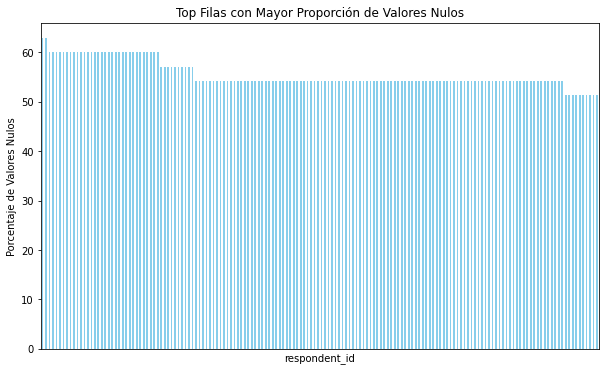

In [5]:
# Visualizar las primeras 200 filas con mayor proporción de valores nulos
plt.figure(figsize=(10, 6))
rows_with_most_missing_sorted['missing_ratio'].plot(kind='bar', color='skyblue')

plt.title('Top Filas con Mayor Proporción de Valores Nulos')
plt.ylabel('Porcentaje de Valores Nulos')
plt.xticks([])
plt.show()

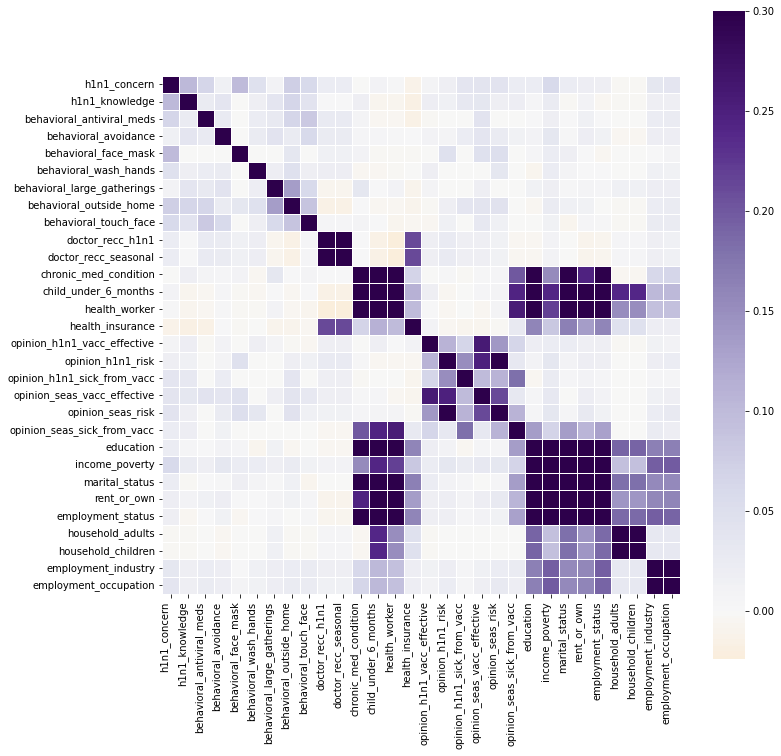

In [6]:
# Eliminar las filas de 'X_train' que están en 'rows_with_most_missing'
X_train_cleaned = X_train.drop(X_train[X_train['missing_ratio'] > 35].index)

# Identificar las columnas con valores nulos en el DataFrame original (joined_df)
columns_with_nulls = X_train.columns[X_train.isna().any()]

# Crear una matriz de correlación solo para columnas con valores nulos
missing_corr = X_train_cleaned[columns_with_nulls].isna().corr()

# Crear el heatmap de correlación
plt.figure(figsize=(10,10))  # Tamaño adecuado para evitar superposición

g = sns.heatmap(missing_corr, vmax=.3, center=0,
                square=True, linewidths=1, fmt='.2f', cmap='PuOr')

# Ajustar los márgenes de la figura
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Rotar las etiquetas de los ejes para mayor legibilidad
plt.xticks(rotation=90, ha='right', fontsize=10)  # Rotar etiquetas del eje X
plt.yticks(rotation=0, ha='right', fontsize=10)   # Etiquetas del eje Y

# Mostrar el gráfico
plt.show()


Eliminamos la columna que se ha añadido de missing ratio

In [7]:
X_train.drop(columns=['missing_ratio'], inplace=True)

In [8]:
def preprocess_data(df, indices_to_keep=None):
    # **Paso 0: Eliminar filas con más del 30% de valores faltantes**
    if indices_to_keep is None:  # Si no se pasan índices, procesamos el conjunto de entrenamiento
        missing_threshold = 0.3
        missing_rate = df.isnull().mean(axis=1)  # Tasa de valores perdidos por fila
        indices_to_keep = missing_rate[missing_rate <= missing_threshold].index  # Índices de filas a conservar
    df = df.loc[indices_to_keep]  # Filtrar filas según índices

    # **Paso 1: Imputación y transformación de columnas específicas**
    df['employment_status'] = df['employment_status'].fillna('Unemployed')
    df[['employment_industry', 'employment_occupation']] = df[['employment_industry', 'employment_occupation']].mask(
        df['employment_status'].isin(['Not in Labor Force', 'Unemployed']), 'Missing'
    )
    df['health_insurance_Missing'] = df['health_insurance'].isna().astype(int)
    df['health_insurance'] = df['health_insurance'].fillna(0).astype(int)

    # **Paso 2: Imputación personalizada**
    ordinal_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
                    'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
                    'opinion_seas_sick_from_vacc']
    for col in ordinal_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        max_value = df[col].max()
        df[col] = df[col].fillna(max_value + 1)

    ordinal_order = {
        'age_group': ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'],
        'education': ['< 12 Years', '12 Years', 'Some College', 'College Graduate', 'Missing'],
        'income_poverty': ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000', 'Missing']
    }
    for col, order in ordinal_order.items():
        df[col] = df[col].fillna('Missing')
        df[col] = pd.Categorical(df[col], categories=order, ordered=True).codes

    binary_cols = [
        'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',
        'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
        'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
        'chronic_med_condition', 'child_under_6_months', 'health_worker'
    ]
    for col in binary_cols:
        df[col] = df[col].fillna(df[col].mean()).round(0).astype(int)

    binary_cols_str = ['sex', 'marital_status', 'rent_or_own']
    mappings = {
        'sex': {'Male': 0, 'Female': 1},
        'marital_status': {'Not Married': 0, 'Married': 1},
        'rent_or_own': {'Own': 0, 'Rent': 1}
    }
    for col, mapping in mappings.items():
        df[col] = df[col].fillna('Missing')
        df[col] = df[col].map(mapping).fillna(-1).astype(int)

    nominal_cols = ['race', 'employment_status', 'hhs_geo_region', 'census_msa',
                    'employment_industry', 'employment_occupation']
    for col in nominal_cols:
        df[col] = df[col].fillna('Missing')

    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    nominal_encoded = one_hot_encoder.fit_transform(df[nominal_cols])
    nominal_encoded_df = pd.DataFrame(
        nominal_encoded,
        columns=one_hot_encoder.get_feature_names_out(nominal_cols),
        index=df.index
    )

    numeric_cols = ['household_adults', 'household_children']
    imputer = KNNImputer(n_neighbors=5)
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    df[numeric_cols] = df[numeric_cols].round(0).astype(int)

    df.drop(columns=nominal_cols, inplace=True)
    df = pd.concat([df, nominal_encoded_df], axis=1)

    return df, indices_to_keep



In [9]:
X_train_preprocessed, indices_to_keep_train = preprocess_data(X_train.copy())
X_test_preprocessed, indices_to_keep_test = preprocess_data(X_test.copy())


In [11]:
X_train_preprocessed.to_csv('../Data/Prueba_Jaime/preprocessed_train_dataset.csv', index=True)
X_test_preprocessed.to_csv('../Data/Prueba_Jaime/preprocessed_test_dataset.csv', index=True)
y_train.loc[indices_to_keep_train].to_csv('../Data/Prueba_Jaime/labels_train_dataset.csv', index=True)
y_test.loc[indices_to_keep_test].to_csv('../Data/Prueba_Jaime/labels_test_dataset.csv', index=True)

In [12]:
print(X_train_preprocessed.columns)


Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'sex', 'income_poverty', 'marital_status', 'rent_or_own',
       'household_adults', 'household_children', 'health_insurance_Missing',
       'race_Black', 'race_Hispanic', 'race_Other or Multiple', 'race_White',
       'employment_status_Employed', 'employment_status_Not in Labor Force',
       'employment_status_Unemployed', 'hhs_geo_region_atmpeygn',
       'hhs_geo_region_bhuqouqj', 'hhs_g

In [ ]:
# Cargar el conjunto de prueba externo y preprocesar
test_set_features = pd.read_csv("C:/Users/er_ja/Desktop/Jaime/Master/Preprocesamiento y Clasificación/Proyecto final/test_set_features.csv", index_col="respondent_id")
test_set_preprocessed = preprocess_data(test_set_features.copy())

# Guardar el conjunto de prueba preprocesado
test_set_preprocessed.to_csv("C:/Users/er_ja/Desktop/Jaime/Master/Preprocesamiento y Clasificación/Proyecto final/preprocessed_test_set_features.csv", index=True)

In [13]:
print(X_train_preprocessed.isnull().sum())

h1n1_concern                      0
h1n1_knowledge                    0
behavioral_antiviral_meds         0
behavioral_avoidance              0
behavioral_face_mask              0
                                 ..
employment_occupation_vlluhbov    0
employment_occupation_xgwztkwe    0
employment_occupation_xqwwgdyp    0
employment_occupation_xtkaffoo    0
employment_occupation_xzmlyyjv    0
Length: 96, dtype: int64


In [14]:
print(X_train_preprocessed.shape)
print(y_train.loc[indices_to_keep_train].shape)
print(X_test_preprocessed.shape)
print(y_test.loc[indices_to_keep_test].shape)


(20739, 96)
(20739, 2)
(5195, 96)
(5195, 2)


In [ ]:
# 1. Dimensiones del dataset
print("Dimensiones del dataset:")
print(f"Filas: {X_train_preprocessed.shape[0]}, Columnas: {X_train_preprocessed.shape[1]}")

# 2. Información del dataset
print("\nInformación general del dataset:")
print(X_train_preprocessed.info())

# 3. Valores faltantes
print("\nValores faltantes por columna (porcentaje):")
missing_values = X_train_preprocessed.isna().mean() * 100
print(missing_values[missing_values > 0])

# 4. Estadísticas descriptivas
print("\nEstadísticas descriptivas del dataset:")
print(X_train_preprocessed.describe())

# 5. Distribución de las variables categóricas (opcional)
print("\nDistribución de algunas variables categóricas:")
categorical_cols = [col for col in X_train_preprocessed.columns if X_train_preprocessed[col].dtype == 'object']
for col in categorical_cols:
    print(f"\nDistribución de '{col}':")
    print(X_train_preprocessed[col].value_counts(normalize=True) * 100)

Dimensiones del dataset:
Filas: 20739, Columnas: 96

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 20739 entries, 12230 to 467
Data columns (total 96 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   h1n1_concern                          20739 non-null  float64
 1   h1n1_knowledge                        20739 non-null  float64
 2   behavioral_antiviral_meds             20739 non-null  int64  
 3   behavioral_avoidance                  20739 non-null  int64  
 4   behavioral_face_mask                  20739 non-null  int64  
 5   behavioral_wash_hands                 20739 non-null  int64  
 6   behavioral_large_gatherings           20739 non-null  int64  
 7   behavioral_outside_home               20739 non-null  int64  
 8   behavioral_touch_face                 20739 non-null  int64  
 9   doctor_recc_h1n1                      20739 non-null  int64  
 10 


Matriz de correlación:
                                h1n1_concern  h1n1_knowledge  \
h1n1_concern                        1.000000        0.053037   
h1n1_knowledge                      0.053037        1.000000   
behavioral_antiviral_meds           0.088708       -0.008509   
behavioral_avoidance                0.221676        0.077987   
behavioral_face_mask                0.158978        0.035175   
...                                      ...             ...   
employment_occupation_vlluhbov      0.017019       -0.040150   
employment_occupation_xgwztkwe     -0.024108        0.014261   
employment_occupation_xqwwgdyp      0.003033       -0.035788   
employment_occupation_xtkaffoo     -0.017033        0.068458   
employment_occupation_xzmlyyjv     -0.010821        0.030834   

                                behavioral_antiviral_meds  \
h1n1_concern                                     0.088708   
h1n1_knowledge                                  -0.008509   
behavioral_antiviral_med

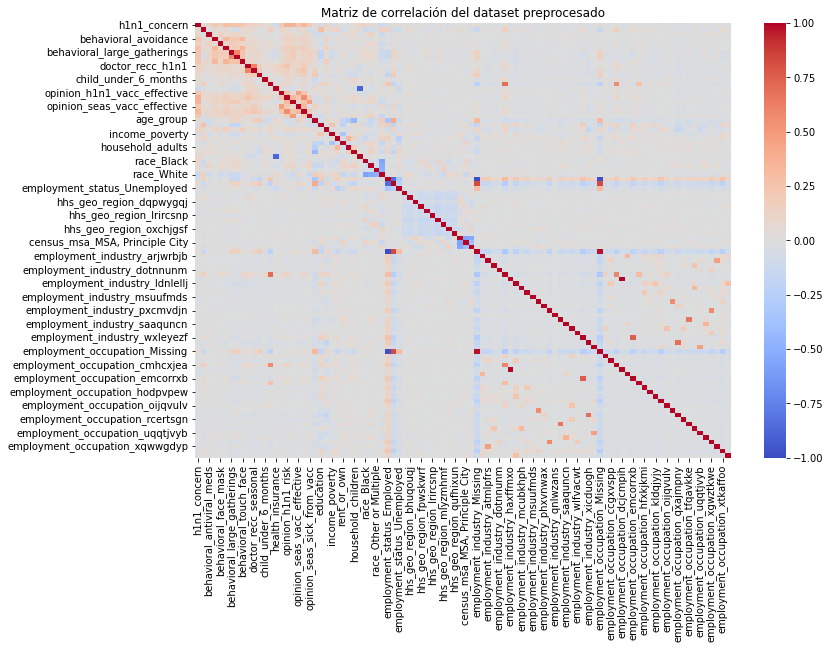

In [15]:
# 6. Correlación entre variables (opcional)
print("\nMatriz de correlación:")
correlation_matrix = X_train_preprocessed.corr()
print(correlation_matrix)

# Visualización opcional de correlaciones altas
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de correlación del dataset preprocesado")
plt.show()

Es obvio que una vez se han codificado todas las variables, resulta casi imposible distinguir correctamente las correlaciones entre variables